In [1]:
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')

# Observation Planning to Velocity Measurement

AST 4723

Last class, we went over how you convert alt/az to a position on the sky.

Now we'll talk about how we determine the velocity of the Earth.

First, reminder poll...

1. How fast do we move with respect to the Earth's axis?
2. How fast do we move around the sun?


In [2]:
from astroplan import Observer
from astropy import units as u, coordinates
from astropy.table import Table
datatable = Table.read('data/psd_200725_100309_tint60s_sdr0_fsw.fits')
obslon = float(datatable.meta['--obs_lon']) * u.deg
obslat = float(datatable.meta['--obs_lat']) * u.deg
location = coordinates.EarthLocation.from_geodetic(obslon, obslat, 100*u.m)
observer = Observer(location, timezone='US/Eastern')
import datetime
obs_time_notz = datetime.datetime.strptime(datatable.meta['DATE-OBS'], "%y%m%d_%H%M%S")
import pytz
tz = pytz.timezone('US/Eastern')
obs_time = tz.localize(obs_time_notz)
alt = float(datatable.meta['--altitude'])
az = float(datatable.meta['--azimuth'])
target_altaz = coordinates.AltAz(alt=alt*u.deg,
                                 az=az*u.deg,
                                 location=observer.location,
                                 obstime=obs_time)
target_altaz


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


<AltAz Coordinate (obstime=2020-07-25 14:03:09, location=(743674.13504562, -5500332.52750589, 3131946.80724394) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>

We need to convert the `AltAz` coordinate to a `SkyCoord`.

In [3]:
skycoord = coordinates.SkyCoord(target_altaz)
skycoord

<SkyCoord (AltAz: obstime=2020-07-25 14:03:09, location=(743674.13504562, -5500332.52750589, 3131946.80724394) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>

Then we can calculate the `radial_velocity_correction`, which defaults to a barycentric correction.

The "barycenter" is the center of mass of the solar system; it moves a little differently from the heliocenter (the center of the sun) because Jupiter wiggles the sun around a bit.

In [4]:
skycoord.radial_velocity_correction()

<Quantity 22488.03312598 m / s>

We'll measure our line now, just like in the Modeling lecture:

In [5]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter()
frequency_axis = datatable['freq1']*u.Hz
fsw_pow = datatable['power1']-datatable['power2']
guess_gaussian = Gaussian1D(amplitude=0.0015, mean=1.4205*u.GHz, stddev=0.0001*u.GHz)
selection = ((frequency_axis > 1420.30*u.MHz) &
             (frequency_axis < 1420.72*u.MHz))
noise_estimate = fsw_pow[~selection].std()
fitted_gaussian = fitter(guess_gaussian, frequency_axis[selection], fsw_pow[selection], weights=1/noise_estimate)
fitted_gaussian

<Gaussian1D(amplitude=0.00149668, mean=1.42051155 GHz, stddev=0.00005981 GHz)>

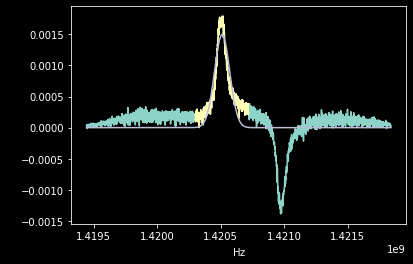

In [6]:
pl.plot(frequency_axis, fsw_pow)
pl.plot(frequency_axis[selection], fsw_pow[selection])
pl.plot(frequency_axis, fitted_gaussian(frequency_axis))

Now we convert our measurement to a radial velocity.

The measurement we make is a *topocentric* measurement.  "Topo" is a prefix relating to the Earth's surface - we're observing from the Earth's surface!

In [7]:
rest_freq = nu_hi = 1420.405751 * u.MHz
velocity_topo = (rest_freq - fitted_gaussian.mean) / rest_freq * constants.c
velocity_topo.to(u.km/u.s)

<Quantity -22.32942494 km / s>

To convert to *barycentric* coordinates, we use the `radial_velocity_correction` we calculated:

In [8]:
velocity_bary = velocity_topo + skycoord.radial_velocity_correction()
velocity_bary

<Quantity 158.60818671 m / s>

Apparently the gas in this direction is moving very slowly with respect to the barycenter.  

We're looking toward the anticenter (away from the Galactic center), so we don't really expect the gas to be moving along the line of sight.

Most motion is azimuthal, around the circle, not in-out.

In [9]:
%pip install https://github.com/keflavich/milkywayplots/archive/e61d1dcd1e5fc4669f0442c52e85f39038a7b4cf.zip

  Using cached https://github.com/keflavich/milkywayplots/archive/e61d1dcd1e5fc4669f0442c52e85f39038a7b4cf.zip
  Created wheel for milkywayplots: filename=milkywayplots-0.1-py3-none-any.whl size=7129 sha256=bbc8c8ebd3ccda4537f101002b6db85272bb11661b94d10ac2420d75b6e18e8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zp0isbwl/wheels/1a/10/ea/41cdff5bec2ead90da78f3810f5a1f41a255be9e83ac111af2
Successfully built milkywayplots
Note: you may need to restart the kernel to use updated packages.


In [10]:
from milkywayplots.milkywayplot import make_mw_plot, get_image
mw_img_name = get_image()
mw_img_name

'Ssc2008-10a1.tif'

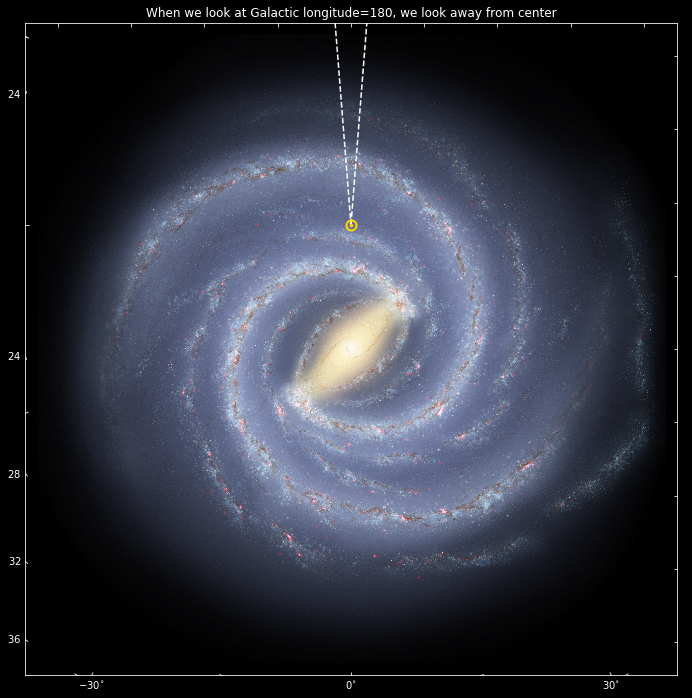

In [11]:
pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot([180-4.5,180-4.5,180+4.5,180+4.5],[0,60,60,0],'w--')
_=pl.title("When we look at Galactic longitude=180, we look away from center")

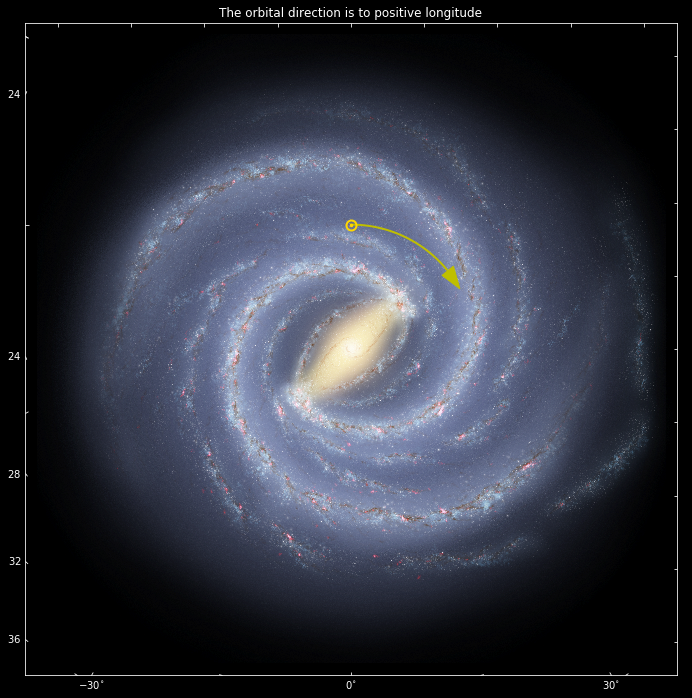

In [12]:
pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
_=gcp.plot(np.linspace(90,40), np.ones(50)*8.5, color='y', linewidth=2)
_=gcp.arrow(40, 8.5, -1, 0, color='y', head_width=1, head_length=10)
_=pl.title("The orbital direction is to positive longitude")

The sun isn't moving much relative to nearby stars.

We call the motion of our local region the "Local Standard of Rest".

In [13]:
skycoord_withvel = coordinates.ICRS(ra=skycoord.icrs.ra, dec=skycoord.icrs.dec,
                                    radial_velocity=velocity_bary,
                                    pm_ra_cosdec=0*u.arcmin/u.yr, pm_dec=0*u.arcmin/u.yr, distance=1*u.pc)
skycoord_withvel

<ICRS Coordinate: (ra, dec, distance) in (deg, deg, pc)
    (71.93099208, 19.56556397, 1.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., 0.15860819)>

In [14]:
lsrcoord = skycoord_withvel.transform_to(coordinates.LSR)
lsrcoord.radial_velocity

<Quantity -12.56843486 km / s>

We'll use "LSR" coordinates to calculate the rotation curve of the Galaxy.

What are we actually observing, though?  The Galaxy is filled with gas!

How do we know what we're seeing?

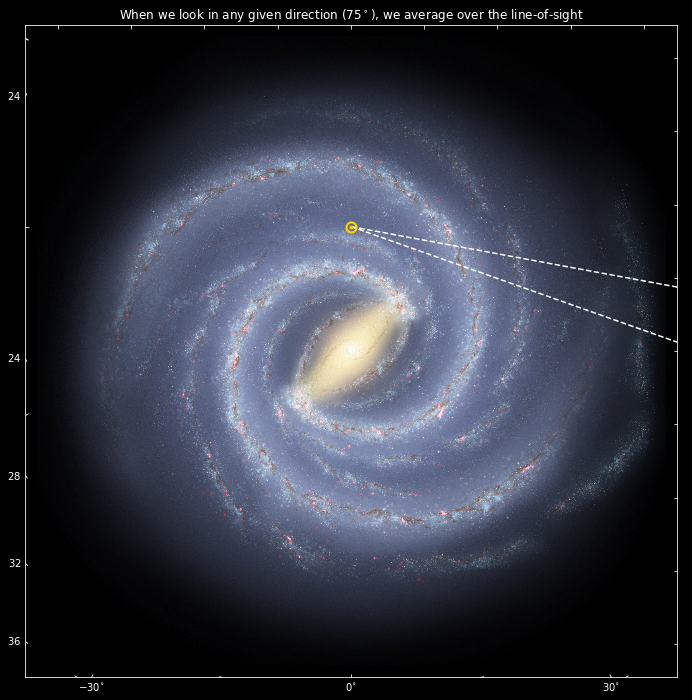

In [15]:
pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot([75-4.5,75-4.5,75+4.5,75+4.5],[0,60,60,0],'w--')
_=pl.title("When we look in any given direction (75$^\circ$), we average over the line-of-sight")

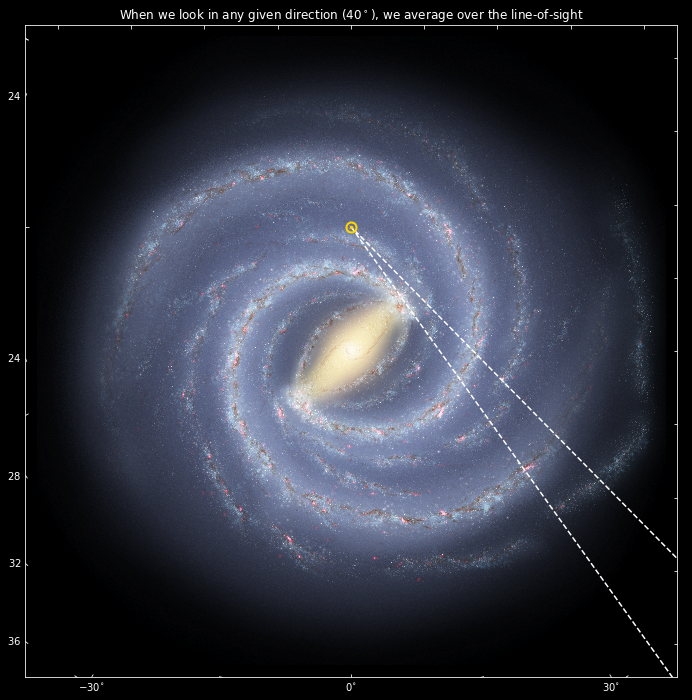

In [16]:
pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot([40-4.5,40-4.5,40+4.5,40+4.5],[0,60,60,0],'w--')
_=pl.title("When we look in any given direction (40$^\circ$), we average over the line-of-sight")

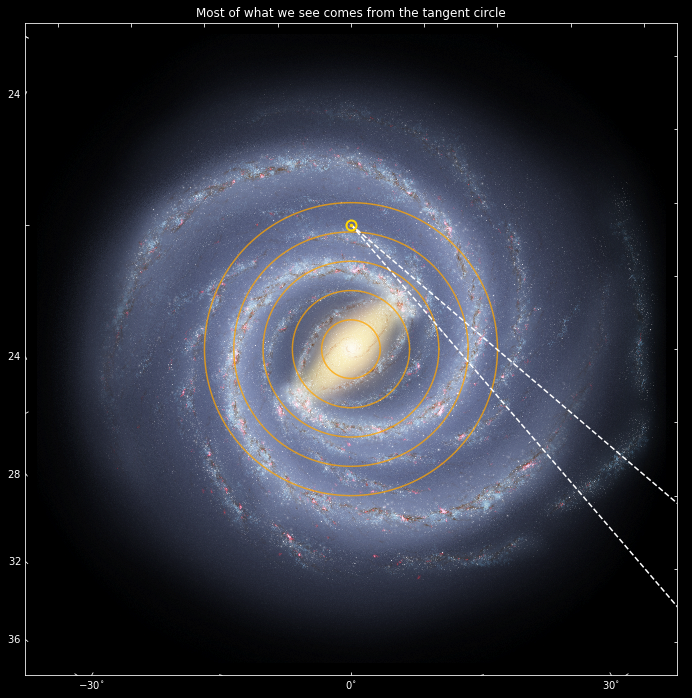

In [17]:
pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
_=gcp.plot(np.linspace(0,360,360),(np.ones(360)[None,:]*np.array([2,4,6,8,10])[:,None]).T, 'orange', alpha=0.75)
obs_angle = 45
_=hcp.plot([obs_angle-4.5,obs_angle-4.5,obs_angle+4.5,obs_angle+4.5],[0,60,60,0],'w--')
_=pl.title("Most of what we see comes from the tangent circle")

In [18]:
# r0 is the distance between the sun and the Galactic center;
# it's somewhere between 8 and 8.5 kpc,
# but the IAU-recommended number is still 8.5 kpc
r0 = 8.5*u.kpc

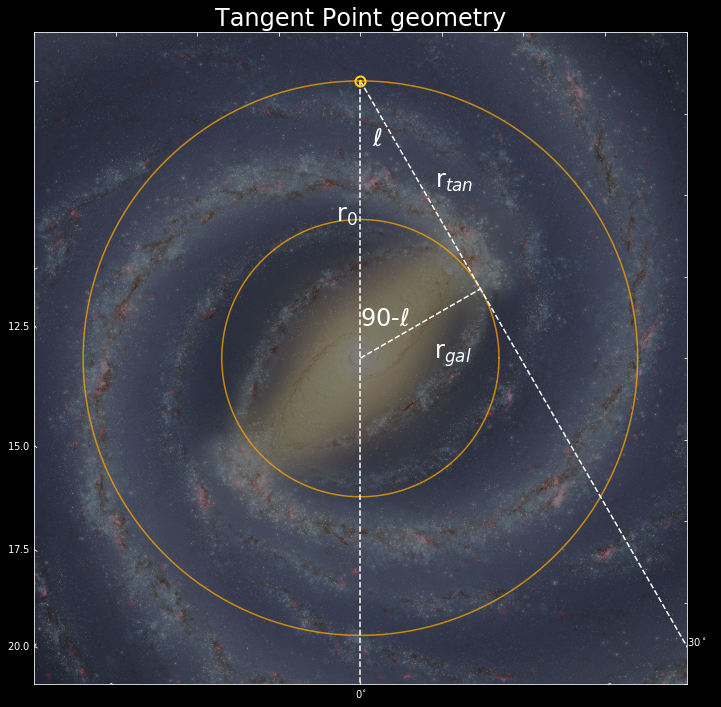

In [19]:
fig = pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
ax.images[0].set_alpha(0.5)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
obs_angle = 30
rmin = np.sin(obs_angle*u.deg) * r0
_=gcp.plot(np.linspace(0,360,360),(np.ones(360)[None,:]*np.array([rmin.value, r0.value])[:,None]).T, 'orange', alpha=0.75)
_=hcp.plot([obs_angle, obs_angle], [0,60,],'w--')
_=hcp.plot([0, 0], [0,60,],'w--')
_=gcp.plot([obs_angle, obs_angle], [0, rmin.value],'w--')
_=hcp.text(obs_angle/3, 2, "$\ell$", fontsize=24)
_=gcp.text(obs_angle*3, 1, "90-$\ell$", fontsize=24)
_=gcp.text(100, 4.25, "r$_0$", fontsize=24)
_=gcp.text(0, 2.25, "r$_{gal}$", fontsize=24)
_=hcp.text(obs_angle+5, 4., "r$_{tan}$", fontsize=24)
_=hcp.text(obs_angle, 20, f"{obs_angle:d}$^\circ$")
_=ax.axis([-10,10,-10,10])
_=pl.title("Tangent Point geometry", fontsize=24)
_=pl.savefig("mw_tangentpoint_geometry.png", bbox_inches='tight')

<img src="mw_tangentpoint_geometry.png">

The tangent point geometry tells you what Galactocentric distance you're observing.

For example, for $\ell=30$, $r_0=8.5$ kpc, $r_{gal} = \sin(\ell) r_0 = 4.25$ kpc.

The velocity we observe is the circular velocity, $v_{orb}$, minus the sun's velocity projected in that direction.

However, the LSR is "at rest" with respect to the galaxy (to the best of our ability to measure it), so we've already subtracted that.

To measure the rotation curve, then, we'll plot our measured $V_{LSR}$ vs the tangent point $r_{gal}$.

Why are we measuring the rotation curve? 

Recall that the orbital velocity of a body in a gravitational potential only depends on the mass interior to that body.

$$v_{orb} = \sqrt{\frac{G M}{R}}$$

If we can measure $v_{orb}$, and we know what $R$ we're observing, we can infer the contained mass, $M$.

$$M = \frac{R_{gal} v_{orb}^2}{G}$$

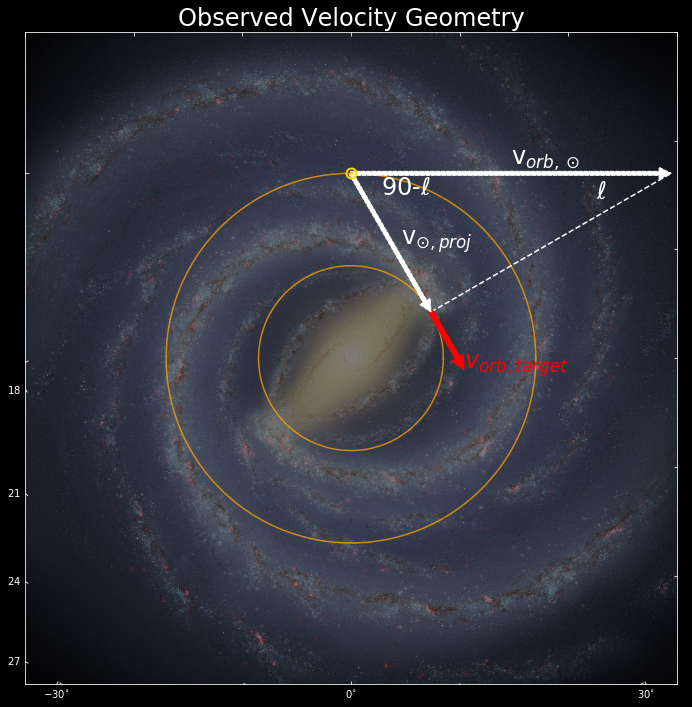

In [20]:
fig = pl.figure(figsize=(12,12), num=5)
ax, ax_pixgrid, gcp, hcp, tr_gal, tr_helio = make_mw_plot(mw_img_name=mw_img_name)
ax.images[0].set_alpha(0.5)
_=hcp.plot(0,0,'o',color='gold',markersize=10,markeredgecolor='gold',markerfacecolor='none',zorder=50,alpha=1,markeredgewidth=2)
_=hcp.plot(0,0,'.',color='gold',markersize=3,markeredgecolor='gold',markerfacecolor='gold',zorder=50,alpha=1,markeredgewidth=2)
obs_angle = 30
rmin = np.sin(obs_angle*u.deg) * r0
_=gcp.plot(np.linspace(0,360,360),(np.ones(360)[None,:]*np.array([rmin.value, r0.value])[:,None]).T, 'orange', alpha=0.75)
#_=hcp.plot([obs_angle, obs_angle], [0,r0.value*np.cos(obs_angle*u.deg),],'w--')
_=hcp.annotate("", xy=[obs_angle,r0.value*np.cos(obs_angle*u.deg)], xytext=[obs_angle, 0],
                             arrowprops=dict(facecolor='white', linestyle='dashed', edgecolor='w', linewidth=1),)
#_=hcp.plot([obs_angle, obs_angle], [r0.value*np.cos(obs_angle*u.deg),] r0.value*np.cos(obs_angle*u.deg)+3],
# color='r', linestyle=':', linewidth=3)
_=hcp.annotate("", xy=[obs_angle, r0.value*np.cos(obs_angle*u.deg)+3],
               xytext=[obs_angle, r0.value*np.cos(obs_angle*u.deg)], color='r', fontsize=24,
              arrowprops=dict(facecolor='red', linewidth=2, edgecolor='r'),)
_=hcp.annotate("$v_{orb,target}$", xy=[obs_angle, r0.value*np.cos(obs_angle*u.deg)+3],
               xytext=[obs_angle, r0.value*np.cos(obs_angle*u.deg)+3], color='r', fontsize=24)
#_=hcp.plot([0, 0], [0,60,],'w--')
_=gcp.plot([obs_angle, obs_angle], [rmin.value, r0.value / np.sin(obs_angle*u.deg)],'w--')
_=gcp.plot([90, obs_angle], [r0.value, r0.value / np.sin(obs_angle*u.deg)],'w--')
#_=hcp.plot([90,90], [0, r0.value/np.tan(obs_angle*u.deg)], 'w--')
_=hcp.annotate("", xy=[90,r0.value/np.tan(obs_angle*u.deg)], xytext=[90,0],
                                            arrowprops=dict(facecolor='white', linewidth=1, linestyle='dashed', edgecolor='w'),)
_=hcp.text(84, r0.value/np.tan(obs_angle*u.deg) * 0.77, "$\ell$", fontsize=24)
_=hcp.text(70-obs_angle/2, 1.7, "90-$\ell$", fontsize=24)
#_=gcp.text(100, 4.25, "r$_0$", fontsize=24)
_=hcp.text(93, r0.value/np.tan(obs_angle*u.deg)/2, "v$_{orb,\odot}$", fontsize=24)
_=hcp.text(obs_angle+5, 4., "v$_{\odot,proj}$", fontsize=24)
#_=hcp.text(obs_angle, 20, f"{obs_angle:d}$^\circ$")
_=ax.axis([-15,15,-15,15])
_=pl.title("Observed Velocity Geometry", fontsize=24)
_=pl.savefig("mw_obsvel_geometry.png", bbox_inches='tight')

<img src="mw_obsvel_geometry.png">

We do have to subtract off the velocity of the sun.  The observed velocity will be:

$$ v_{obs} = v_{orb,target} - v_{orb,\odot} \sin \ell $$

If we want to determine $v_{orb}$, we solve for it:
$$v_{orb,target} = v_{obs} + v_{orb,\odot} \sin \ell$$

The orbital velocity of the sun and the star are both model-dependent, though: 
$$v=\sqrt{\frac{G M}{R}}$$
so $v_{orb,\odot} = \sqrt{\frac{G M(R_\odot)}{R_\odot}}$ and $v_{orb,tgt} = \sqrt{\frac{G M(R_{tgt})}{R_{tgt}}}$

(I switched from 'target' to 'tgt' to keep the variable name shorter)

We can examine some example cases. 


For a flat rotation curve, $M(R) \propto R$, so $v_{orb,\odot} = v_{orb,tgt}$.  In that case, we would get:

$$v_{obs} = v_{orb} ( 1 - \sin \ell )$$

which lets us solve for $M$ easily:

$$M = \left[ \frac{v_{obs} }{1-\sin\ell} \right]^2 \frac{R}{G}$$

We can then solve for $M(R)$ at $R=R_{tgt}$ or $R=R_\odot$

For a solid-body rotation curve, $v\propto R$, or $M(R)\propto R^2$.  In this case, $v\propto\sqrt{G R}$, so $v_{orb,tgt}=\sqrt{c G R_{tgt}}$ and $v_{orb,\odot} = \sqrt{c G R_\odot}$.

If we combine those equations, we get $v_{orb, tgt} = v_{orb,\odot} \frac{R_{tgt}}{R_\odot}$.

But $R_{tgt} = R_{\odot} \sin \ell$, so $v_{orb,tgt} = v_{orb,\odot} \sin \ell$.

Then, plugging that in to $$ v_{obs} = v_{orb,target} - v_{orb,\odot} \sin \ell $$ we get

$$v_{obs} = v_{orb,tgt} - v_{orb,tgt} \frac{R_\odot}{R_{tgt}}\sin \ell$$
or
$$v_{obs} = v_{orb,tgt} \left(1 -  \frac{R_\odot}{R_{tgt}}\sin \ell\right)$$

But that reduces to $v_{obs}=0$


Solve for $M$ again:

$$M = \left[ \frac{v_{obs} }{1- \frac{R_\odot}{R_{tgt}}\sin\ell} \right]^2 \frac{R}{G}$$


In the observing project, our goal is to determine which of these rotation curves is most appropriate to use and use it!

The IAU standard from 1985 is $v_{orb,\odot} = 220$ km/s, which you can use to see if we get anything close.

For some more details about how correct the simple tangent assumption is, this paper gives a nice overview:
https://ui.adsabs.harvard.edu/abs/2017PASJ...69R...1S/abstract


You can see other students' attempts at these measurements:
http://www.astro.wisc.edu/~sstanimi/Students/Astro460Poster_2015.pdf

FIN